# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.
Построим модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Критерии, которые важны заказчику:**

- метрика RMSE оценки качества предсказания менее 2500;
- скорость предсказания;
- время обучения.

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

- `Price` — цена (евро)


## Подготовка данных

### Знакомство с данными

Загружаем библиотеки для работы

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Создаём датафрейм из исходного файла

In [2]:
try:
    autos = pd.read_csv('autos.csv')
except:
    autos = pd.read_csv('/datasets/autos.csv')

Ознакомимся с полученными данными

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сразу же отсечем неважную для оценки стоимости автомобиля информацию: 
- дату скачивания анкеты
- месяц регистрации автомобиля т.к. при определении цены используют год
- дату создания анкеты
- количество фотографий
- индекс владельца анкеты
- дату последней активности пользователя

А также, взглянем на оставшиеся столбцы повнимательней

In [4]:
autos = autos.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Видно, что в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`, имеются пропуски. Оценим визуально 10 случайных строк датафрейма.

In [5]:
autos.sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
34131,8850,wagon,2005,auto,140,passat,150000,gasoline,volkswagen,no
121092,2450,small,2007,manual,58,clio,150000,petrol,renault,yes
133183,7250,sedan,2010,manual,125,leon,90000,petrol,seat,yes
205983,14950,suv,2009,auto,140,tiguan,150000,gasoline,volkswagen,no
162619,250,small,1996,manual,0,megane,150000,lpg,renault,NaN
135943,3500,bus,2006,manual,140,touran,150000,gasoline,volkswagen,yes
47049,5500,NaN,2017,auto,150,vectra,150000,NaN,opel,no
159644,4990,small,1975,manual,75,golf,150000,petrol,volkswagen,no
94018,4490,bus,2006,manual,140,touran,150000,gasoline,volkswagen,no
118525,19500,sedan,2012,manual,184,1er,80000,gasoline,bmw,no


Бросается в глаза только нули в столбце с мощностью двигателя. Может быть статистические параметры дадут нам больше информации

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


В столбцах с ценой, годом регистрации и уже упомянутой мощностью явно есть аномальные данные. Бесплатные автомобили возрастом более 1000 лет и нулевой мощностью вряд ли существуют. Значит понадобится работа с выбросами.

### Итоги знакомства с данными

Удалены неважные для оценки стоимости автомобиля столбцы: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`

Обнаружены пропуски в столбцах в пяти столбцах.

Обнаружены аномальные значения в столбцах `Price`, `RegistrationYear`, `Power`

Итоговый план предобработки таков:
1. Заполняем пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`
2. Удаляем аномальные данные, судя по квантилям их не так много. При удалении обратимся к здравому смыслу, чтобы избавиться лишь от явной белиберды.

### Работа с пропусками

Думаю, что оптимальной тактикой для нашего датасета станет заполнение пропусков наиболее частовстречающимся значением. С типом кузова и типом топлива будем ориентироваться на бренд - для разных брендов возможны разные популярные значения.

#### Работа со столбцом `VehicleType`

Посмотрим сколько пропусков и разных значений в столбце.

In [7]:
autos['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Пропусков более 10% удалять нельзя. При этом уникальных значений не так уж и много. Создадим сводную таблицу с количеством каждого типа кузова для каждого бренда

In [8]:
vehicle_type_table = autos.pivot_table(index=['VehicleType'], 
                                       columns=['Brand'],
                                       values=['Price'],
                                       aggfunc=['count'])

display(vehicle_type_table)

count                                                      \
                 Price                                                       
Brand       alfa_romeo     audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                  
bus                NaN     10.0      7.0     159.0    436.0  1262.0   50.0   
convertible      180.0   1627.0   3266.0      17.0    238.0   114.0    NaN   
coupe            229.0   1499.0   3809.0      90.0     48.0   152.0    NaN   
other             15.0    110.0    242.0      46.0     10.0   121.0    6.0   
sedan            945.0  10965.0  17585.0     231.0    295.0   714.0  103.0   
small            239.0   1571.0    448.0     582.0     12.0  1590.0  223.0   
suv                1.0    180.0    818.0     384.0     23.0    36.0  215.0   
wagon            457.0  11081.0   7929.0     110.0    244.0   629.0  252.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           27.0     36.0   833.0  ...   614.0   231.0     1.0   
convertible    1.0     17.0   520.0  ...     NaN     4.0  1132.0   
coupe          8.0      NaN   177.0  ...    87.0    10.0   341.0   
other          5.0     12.0   184.0  ...    74.0    26.0     9.0   
sedan        107.0     47.0   904.0  ...  1781.0   911.0    29.0   
small        268.0    527.0  5308.0  ...  3119.0  1124.0  3267.0   
suv            1.0     49.0    24.0  ...     4.0   173.0     NaN   
wagon         47.0     17.0   455.0  ...   399.0  2709.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  202.0   17.0   28.0   447.0     NaN     9536.0     NaN  
convertible          330.0    1.0   36.0    65.0    37.0     2963.0    75.0  
coupe                230.0    8.0    8.0   232.0     4.0     1784.0    69.0  
other                256.0    6.0   14.0    21.0     7.0      760.0     5.0  
sedan                486.0  168.0  183.0   895.0   230.0    19738.0   643.0  
small                261.0  119.0  985.0  1588.0    58.0    18531.0     7.0  
suv                  429.0   62.0  749.0   445.0     1.0     1331.0   221.0  
wagon                139.0  300.0   89.0   572.0    79.0    12660.0  1989.0  

[8 rows x 40 columns]

В результате получили мультииндекс. Избавимся от него и проконтролируем результат

In [9]:
vehicle_type_table.columns = vehicle_type_table.columns.droplevel([0,1])
display(vehicle_type_table.columns)

Index(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen',
       'volvo'],
      dtype='object', name='Brand')

От мультииндекса избавились. Напишем функцию для заполнения пропусков: на вход она принимает строку датафрейма, индекс столбца с типом кузова и таблицу с популярными типами кузова для каждого бренда

In [10]:
autos.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_table):
    # запишем в переменную бренд из обрабатываемой строки
    # 8 - индекс столбца датафрейма autos
    brand = row[8] 
    # запишем в переменную тип кузова из обраб. строки
    fill_value = row[row_number]
    # если тип кузова 0, то присваеваем ему значение найденное в таблице
    # с популярными типами кузова по брендам
    if row[row_number] == 0:
        fill_value = vehicle_type_table[brand].idxmax()
    return fill_value

Произведем замену и оценим результат

In [11]:
autos['VehicleType'] = autos.apply(fillna_by_brand, 
                                   args=[1, vehicle_type_table], # 1 - индекс столбца с типом кузова
                                   axis=1)

autos['VehicleType'].value_counts(dropna=False)

sedan          109309
small           95881
wagon           68224
bus             28908
convertible     20283
coupe           16163
suv             12313
other            3288
Name: VehicleType, dtype: int64

Добавилось порядка 18 тыс. седанов и 16 тыс. малолитражек, а также по мелочам в остальные группы.

#### Работа со столбцом `Gearbox`

Посмотрим на значения столбца с типом коробки передач

In [12]:
autos['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

Пропусков чуть более 5%. Заменим самым популярным значением и проконтролируем результат.

In [13]:
autos['Gearbox'] = autos['Gearbox'].fillna('manual')
autos['Gearbox'].value_counts(dropna=False)

manual    288084
auto       66285
Name: Gearbox, dtype: int64

Порядок. Пропусков нет.

#### Работа со столбцом `Model`

Посмотрим уникальные значения

In [14]:
autos['Model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

Даже визуально видно, что различных моделей много, а пропусков в чуть более 5% строк встречаются. В такой ситуации, думаю, можно спокойно заменить это количество просто словом *unknown*

In [15]:
autos['Model'] = autos['Model'].fillna('unknown')
autos['Model'].value_counts(dropna=False)

golf                  29232
other                 24421
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 251, dtype: int64

Успешно. Двигаемся дальше

#### Работа со столбцом `FuelType`

Взглянем на уникальные значения

In [16]:
autos['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Здесь тактика та же, что и с типом кузова, т.к. пропусков порядка 10%. Заполним популярным значением по модели.

Создаём таблицу с популярными типами топлива по брендам, избавляемся от мультииндекса, контролируем результат.

In [17]:
fuel_type_table = autos.pivot_table(index=['FuelType'], 
                                       columns=['Brand'],
                                       values=['Price'],
                                       aggfunc=['count'])

fuel_type_table.columns = fuel_type_table.columns.droplevel([0,1])
display(vehicle_type_table.columns)

Index(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen',
       'volvo'],
      dtype='object', name='Brand')

Порядок. Приступаем к заполнению.

In [18]:
autos.fillna({'FuelType':0},inplace=True)

autos['FuelType'] = autos.apply(
                                fillna_by_brand, 
                                args=[7, fuel_type_table],
                                axis=1)

autos['FuelType'].value_counts(dropna=False)

petrol      249220
gasoline     98747
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

Похоже, можно было не заморачиваться, 27 пропусков заполнено значением gasoline, а остальные 32 868 - petrol. Но что сделано, то сделано :-)

#### Работа со столбцом `Repaired`

In [19]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [20]:
autos['Repaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: Repaired, dtype: int64

Вряд ли есть какая-то дикая зависимость между "был в ремонте" и брендом, поэтому заполним пропуски значением *no*

In [21]:
autos.fillna({'Repaired':'no'},inplace=True)
autos['Repaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: Repaired, dtype: int64

Готово!

#### Итоги работы с пропусками

In [22]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Как видим, пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заполнены.

В ходе этой работы успешно применена тактика заполнения пропусков самым популярным значением, а в столбцах `VehicleType`, `FuelType` это сделано с учетом бренда

### Работа с выбросами

Рассмотрим столбцы с количественными переменными

#### Столбец `Price`

Построим гистограмму

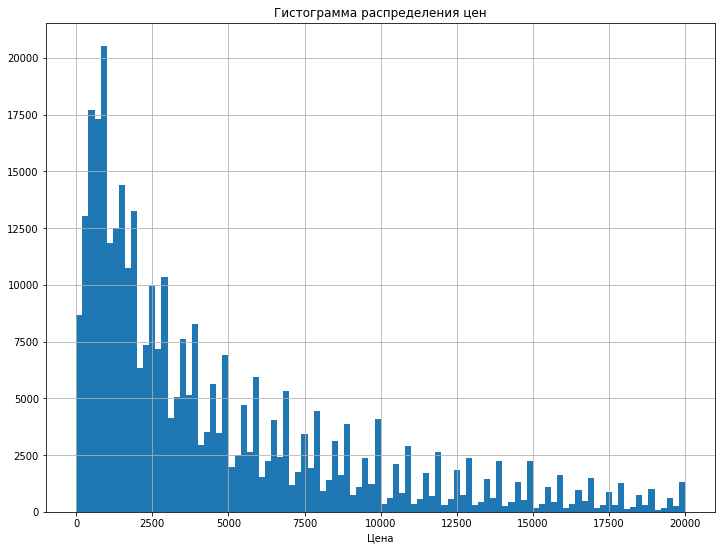

In [23]:
autos.query('Price > 0')['Price'].hist(bins=100, figsize=(12,9))

plt.xlabel('Цена')
plt.title('Гистограмма распределения цен')
plt.show()

Видим достаточное количество записей с ценой около нуля. Взглянем поближе на гистограмму распределения цен в диапазоне от 0 до 1000.

<AxesSubplot:>

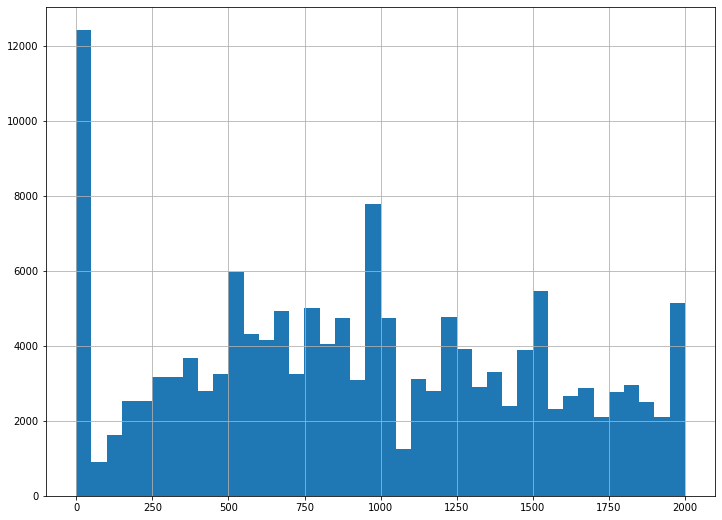

In [24]:
autos.query('2000 > Price')['Price'].hist(bins=40, figsize=(12,9))

Относительно резко количество предложений растет до 250 (ноль не учитываем - явная аномалия), после этой границы рост гораздо менее выраженный, а где-то вообще понижение количества предложений. Поэтому цена 250 видится мне нижней границей бюджетного сегмента автомобилей. Отсечем аномалии и движемся дальше.

In [25]:
autos = autos.query('Price > 249')

In [26]:
autos['Price'].count()

334378

Порядка 6% записей удалено.

#### Столбец `RegistrationYear`

Взглянем на гистограмму

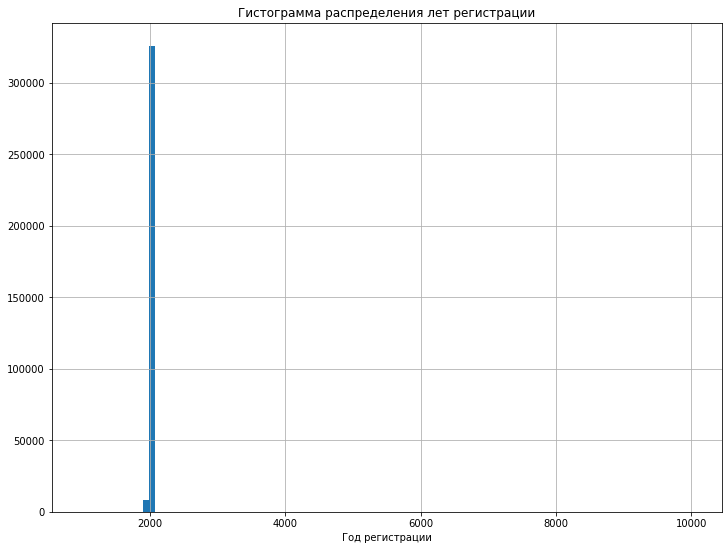

In [27]:
autos['RegistrationYear'].hist(bins=100, figsize=(12,9))

plt.xlabel('Год регистрации')
plt.title('Гистограмма распределения лет регистрации')
plt.show()

Похоже есть совсем уж нереалистичные выбросы как в большую, так и в меньшую сторону, поэтому явно нужно подобрать адекватные рамки. 

Думаю, что резонно оставить года с 1970 (раритетные и дорогие авто таких годов вполне возможно найти на рынке) по 2016 (год выгрузки базы). 

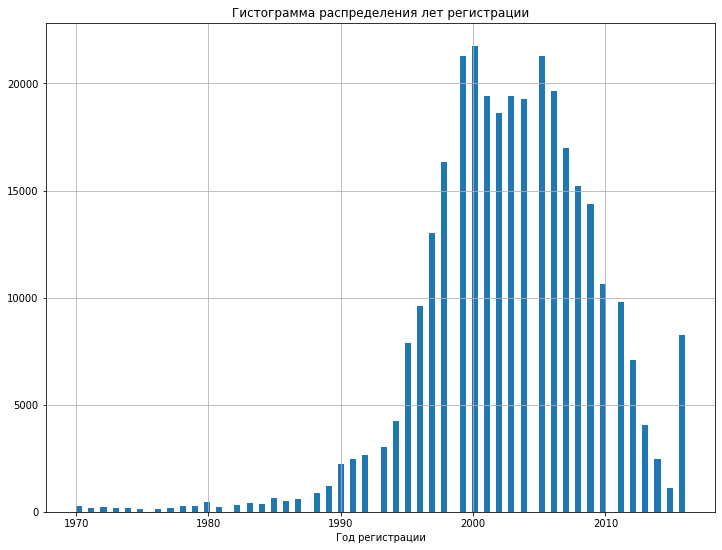

In [28]:
autos.query('2017 > RegistrationYear > 1969')['RegistrationYear'].hist(bins=100, figsize=(12,9))

plt.xlabel('Год регистрации')
plt.title('Гистограмма распределения лет регистрации')
plt.show()

Гистограмма с нашими ограничениями выглядит вполне адекватно, кроме всплеска 2016 года регистрации. Возможно это связано с большим количеством объявлений с новыми автомобилями от автосалонов. Как-то править это, думаю, не стоит.

Отсечем выбросы

In [29]:
autos = autos.query('2017 > RegistrationYear > 1969')

In [30]:
autos['RegistrationYear'].count()

319727

Осталось порядка 90% изначальной выборки

#### Столбец `Power`

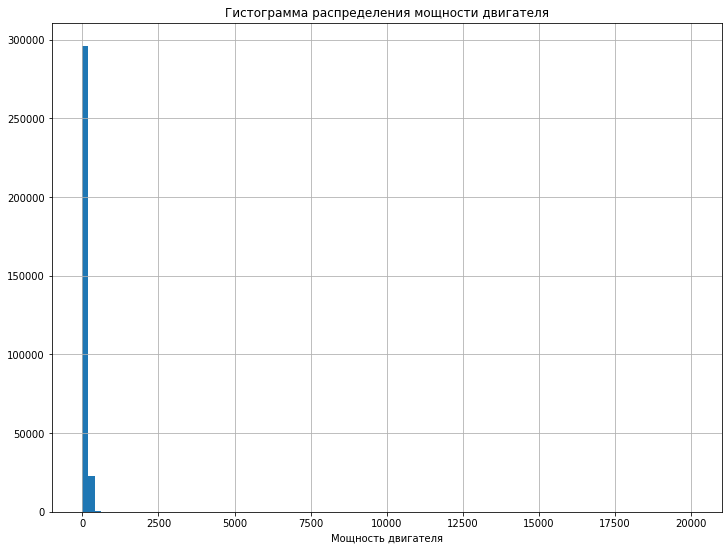

In [31]:
autos['Power'].hist(bins=100, figsize=(12,9))

plt.xlabel('Мощность двигателя')
plt.title('Гистограмма распределения мощности двигателя')
plt.show()

Видим огромные выбросы в большую сторону. Вроде бы при анализе не были замечены космические ракеты, поэтому отсечём выбросы адекватными рамками: 5 л.с. самый маломощный более менее современный автомобиль, 700 л.с. самый мощный, который можно встретить на дорогах общего пользования.

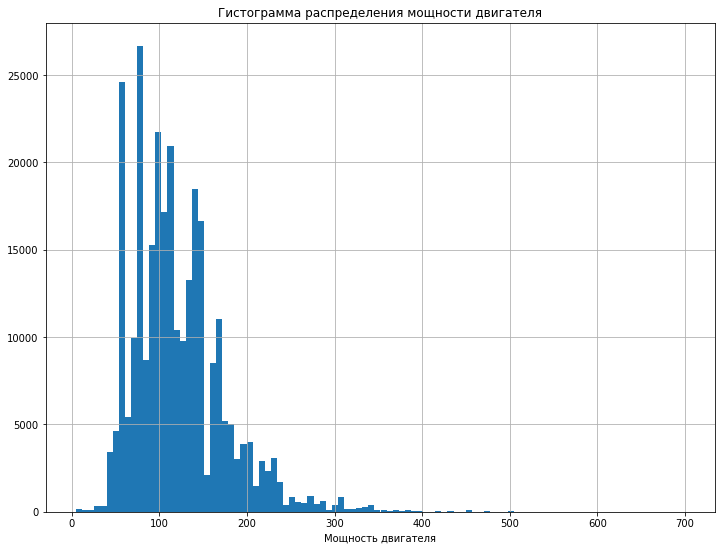

In [32]:
autos.query('701 > Power > 4')['Power'].hist(bins=100, figsize=(12,9))

plt.xlabel('Мощность двигателя')
plt.title('Гистограмма распределения мощности двигателя')
plt.show()

Видим всплески около 60 л.с. и 80 л.с., что неудивительно, малолитражки достаточно популярны из-за доступности покупки и стоимости эксплуатации. Отсечём и оценим потери.

In [33]:
autos = autos.query('700 > Power > 5')

In [34]:
autos['Power'].count()

290141

82% выборки осталось. Многовато, конечно, исключили, но оставшихся почти 300 тыс. адекватных экземпляров будет вполне достаточно, чтобы построить модель.

#### Столбец `Kilometer`

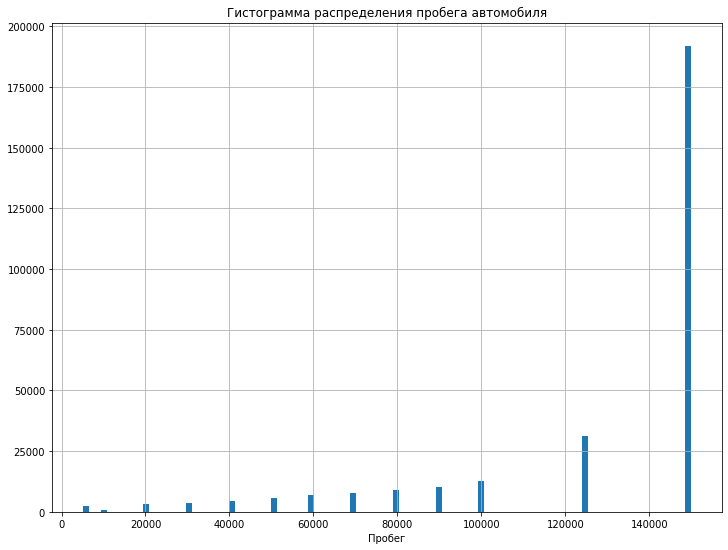

In [35]:
autos['Kilometer'].hist(bins=100, figsize=(12,9))

plt.xlabel('Пробег')
plt.title('Гистограмма распределения пробега автомобиля')
plt.show()

Судя по гистограмме, большая часть продаваемых автомобилей с пробегом в 150 000 км., что вполне согласуется с реальностью.

#### Итоги работы с выбросами

После удаления записей возникают проблемы с пропавшими индексами. Исправим это и посмотрим, что получилось в итоге.

In [36]:
autos = autos.reset_index(drop=True)
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290141 entries, 0 to 290140
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             290141 non-null  int64 
 1   VehicleType       290141 non-null  object
 2   RegistrationYear  290141 non-null  int64 
 3   Gearbox           290141 non-null  object
 4   Power             290141 non-null  int64 
 5   Model             290141 non-null  object
 6   Kilometer         290141 non-null  int64 
 7   FuelType          290141 non-null  object
 8   Brand             290141 non-null  object
 9   Repaired          290141 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.1+ MB


Итого, после удаления выбросов в столбцах `Price`, `RegistrationYear`, `Power`, мы оставили в датасете 82% исходных данных.

### Подготовка признаков

Подготовим признаки для обучения. Так как будем тестировать несколько моделей регрессии (а у нас задача регрессии), которые могут быть чувствительны к типам данных, то предварительно подготовим три датасета с признаками:

- признаки без изменений (catboost переварит точно)
- признаки с ohe-кодированием 
- масштабированные ohe-признаки

In [38]:
features = autos.drop(['Price'], axis=1) #признаки
target = autos['Price'] # целевой признак

# делим на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=12345)

# проверяем размеры выборок
for data in [features_train, features_test, target_train, target_test]:
    print(data.shape)

(217605, 9)
(72536, 9)
(217605,)
(72536,)


Разделение произошло корректно. Произведем кодирование признаков тренировочной и тестовой выборок.

In [39]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

transformer = make_column_transformer((OneHotEncoder(drop='first'), cat_columns), remainder='passthrough')

ohe_features = transformer.fit_transform(features_train).toarray()
ohe_features_train = pd.DataFrame(ohe_features, columns=transformer.get_feature_names())

ohe_features = transformer.transform(features_test).toarray()
ohe_features_test = pd.DataFrame(ohe_features, columns=transformer.get_feature_names())

for column in transformer.get_feature_names():
    ohe_features_train[column] = ohe_features_train[column].astype('int')
    ohe_features_test[column] = ohe_features_test[column].astype('int')
    
print(ohe_features_train.shape)
print(ohe_features_test.shape)
display(ohe_features_train.head())

(217605, 306)
(72536, 306)


,onehotencoder__x0_convertible,onehotencoder__x0_coupe,onehotencoder__x0_other,onehotencoder__x0_sedan,onehotencoder__x0_small,onehotencoder__x0_suv,onehotencoder__x0_wagon,onehotencoder__x1_manual,onehotencoder__x2_145,onehotencoder__x2_147,...,onehotencoder__x4_subaru,onehotencoder__x4_suzuki,onehotencoder__x4_toyota,onehotencoder__x4_trabant,onehotencoder__x4_volkswagen,onehotencoder__x4_volvo,onehotencoder__x5_yes,RegistrationYear,Power,Kilometer
0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1997,90,150000
1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,2013,184,60000
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1997,45,150000
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,2011,101,10000
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2005,160,150000


Судя по размерам выборок и чисто визуально, кодирование прошло успешно.

Приступаем к масштабированию ohe-признаков тестовой и тренировочной выборок.

In [40]:
scaled_features_train = ohe_features_train.copy()
scaled_features_test = ohe_features_test.copy()

# создаём "масштабатор"
scaler = StandardScaler()
# тренируем "масштабатор"
scaled_features_train = scaler.fit_transform(scaled_features_train)
scaled_features_test = scaler.transform(scaled_features_test)

display(scaled_features_train)

array([[-0.26115985, -0.22795544, -0.09112346, ..., -0.96648921,
        -0.58491495,  0.59274839],
       [-0.26115985, -0.22795544, -0.09112346, ...,  1.61406072,
         1.16066485, -1.86342803],
       [-0.26115985, -0.22795544, -0.09112346, ..., -0.96648921,
        -1.42056485,  0.59274839],
       ...,
       [-0.26115985,  4.38682217, -0.09112346, ..., -0.16006735,
         3.42620458, -0.77179407],
       [-0.26115985, -0.22795544, -0.09112346, ..., -0.32135172,
         1.45778481,  0.59274839],
       [-0.26115985, -0.22795544, -0.09112346, ...,  0.32378576,
         0.34358494,  0.59274839]])

Признаки отмасштабированы. 

### Итоги подготовки данных

Удалены неважные для оценки стоимости автомобиля столбцы: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`

Пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` заполнены самым популярным значением, причём в столбцах `VehicleType`, `FuelType` это сделано с учетом бренда

Удалили выбросы в столбцах `Price`, `RegistrationYear`, `Power`, и оставили в датасете 82% исходных адекватных данных.

Подготовили выборки для подбора параметров и тестирования моделей.

Подготовили признаки для обучения, сформировав три датасета: исходный, кодированный OHE и масштабированный OHE

## Подбор гиперпараметров моделей

Используем следующие модели для прогнозирования:
1. LinearRegression
2. DecisionTreeRegressor
3. CatBoostRegressor
4. LGBMRegressor

Для оценки качества моделей подготовим функцию расчёта метрики RMSE

### LinearRegression

Рассмотрим классическую линейную регрессию на закодированных признаках

In [41]:
model_lr = LinearRegression()
lr_crossval_rmse = cross_val_score(model_lr, ohe_features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')
lr_ohe_rmse = round(lr_crossval_rmse.mean(), 2)
print(f'Средний показатель RMSE линейной регрессии (кросс-валидация): {lr_ohe_rmse}')

Средний показатель RMSE линейной регрессии (кросс-валидация): -2566.03


А также проверим, как она сработает на масштабированных признаках

In [42]:
model_lr = LinearRegression()
lr_crossval_rmse = cross_val_score(model_lr, scaled_features_train, target_train, cv=5, scoring='neg_root_mean_squared_error')
lr_scaled_rmse = round(lr_crossval_rmse.mean(), 2)
print(f'Средний показатель RMSE линейной регрессии (кросс-валидация): {lr_scaled_rmse}')

Средний показатель RMSE линейной регрессии (кросс-валидация): -2566.03


Как видим, линейная регрессия с базовыми настройками даёт результат по RMSE больше 2500, поэтому вряд ли она подойдёт для заказчика

### DecisionTreeRegressor

Регрессия "Дерево решений" должна дать результат повыше. Проверим аналогично линейной регрессии, но поподбираем гиперпараметр max_depth с помощью GridSearchCV

#### DTR на OHE-признаках

In [43]:
model_dtr = DecisionTreeRegressor(random_state=12345)
hyperparams = {'max_depth':[x for x in range(5, 20)]}

clf = GridSearchCV(model_dtr, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(ohe_features_train, target_train)

dtr_ohe_model = clf.best_estimator_
dtr_ohe_rmse = clf.best_score_

print(f'Лучшая модель DecisionTreeRegressor')
print(dtr_ohe_model)
print()
print(f'Лучший показатель RMSE DecisionTreeRegressor (кросс-валидация): {dtr_ohe_rmse}')

Лучшая модель DecisionTreeRegressor
DecisionTreeRegressor(max_depth=18, random_state=12345)

Лучший показатель RMSE DecisionTreeRegressor (кросс-валидация): -1818.5430698704563


Гораздо лучше линейной регрессии в базе, посмотрим, как влияет масштабирование.

#### DTR на масштабированных OHE-признаках

In [44]:
model_dtr = DecisionTreeRegressor(random_state=12345)
hyperparams = {'max_depth':[x for x in range(5, 20)]}

clf = GridSearchCV(model_dtr, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(scaled_features_train, target_train)

dtr_scaled_model = clf.best_estimator_
dtr_scaled_rmse = clf.best_score_

print(f'Лучшая модель DecisionTreeRegressor')
print(dtr_scaled_model)
print()
print(f'Лучший показатель RMSE DecisionTreeRegressor (кросс-валидация): {dtr_scaled_rmse}')

Лучшая модель DecisionTreeRegressor
DecisionTreeRegressor(max_depth=18, random_state=12345)

Лучший показатель RMSE DecisionTreeRegressor (кросс-валидация): -1817.452557756431


Масштабирование незначительно улучшило результат. Я бы сказал, статистически незначимо.

### CatBoostRegressor

Данная модель позволяет использовать некодированные признаки, поэтому попробуем подобрать гиперпараметры на ohe-признаках и на масштабированных ohe-признаках и применить лучшую из них для оценки работы модели на некодированных признаках.

#### CatBoostRegressor на OHE-признаках

In [45]:
cbr_model = CatBoostRegressor(random_state=12345) 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'verbose':[False]}]

clf = GridSearchCV(cbr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(ohe_features_train, target_train)

cbr_ohe_model = clf.best_estimator_
cbr_ohe_params = clf.best_params_
cbr_ohe_rmse = clf.best_score_

print(f'Лучшая модель CatBoostRegressor')
print(cbr_ohe_params)
print()
print(f'Лучший показатель RMSE CatBoostRegressor (кросс-валидация): {cbr_ohe_rmse}')

Лучшая модель CatBoostRegressor
{'learning_rate': 0.5, 'verbose': False}

Лучший показатель RMSE CatBoostRegressor (кросс-валидация): -1534.667656601618


Получили ещё большее улучшение показателя RMSE. А как повлияет масштабирование?

#### CatBoostRegressor на масштабированных OHE-признаках

In [46]:
cbr_model = CatBoostRegressor(random_state=12345) 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'verbose':[False]}]

clf = GridSearchCV(cbr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(scaled_features_train, target_train)

cbr_scaled_model = clf.best_estimator_
cbr_scaled_params = clf.best_params_
cbr_scaled_rmse = clf.best_score_

print(f'Лучшая модель CatBoostRegressor')
print(cbr_scaled_params)
print()
print(f'Лучший показатель RMSE CatBoostRegressor (кросс-валидация): {cbr_scaled_rmse}')

Лучшая модель CatBoostRegressor
{'learning_rate': 0.5, 'verbose': False}

Лучший показатель RMSE CatBoostRegressor (кросс-валидация): -1534.667656601618


RMSE осталось прежней, масштабирование не влияет на эту метрику. Поработаем на некодированных признаках.

#### CatBoostRegressor на некодированных признаках

Изменим тип столбцов с категориальными признаками на *category*

In [47]:
features_cat_train = features_train.copy()

for column in cat_columns:
    features_cat_train[column] = features_cat_train[column].astype('category')
    
features_cat_train = features_cat_train.reset_index(drop=True)
features_cat_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217605 entries, 0 to 217604
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       217605 non-null  category
 1   RegistrationYear  217605 non-null  int64   
 2   Gearbox           217605 non-null  category
 3   Power             217605 non-null  int64   
 4   Model             217605 non-null  category
 5   Kilometer         217605 non-null  int64   
 6   FuelType          217605 non-null  category
 7   Brand             217605 non-null  category
 8   Repaired          217605 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.4 MB


In [48]:
features_cat_test = features_test.copy()

for column in cat_columns:
    features_cat_test[column] = features_cat_test[column].astype('category')
    
features_cat_test = features_cat_test.reset_index(drop=True)
features_cat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72536 entries, 0 to 72535
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       72536 non-null  category
 1   RegistrationYear  72536 non-null  int64   
 2   Gearbox           72536 non-null  category
 3   Power             72536 non-null  int64   
 4   Model             72536 non-null  category
 5   Kilometer         72536 non-null  int64   
 6   FuelType          72536 non-null  category
 7   Brand             72536 non-null  category
 8   Repaired          72536 non-null  category
dtypes: category(6), int64(3)
memory usage: 2.2 MB


Помним, что модели нужно указать столбцы с категориальными признаками.

In [49]:
cbr_model = CatBoostRegressor(cat_features=cat_columns, random_state=12345) 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'verbose':[False]}]

clf = GridSearchCV(cbr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(features_train, target_train)

cbr_nocode_model = clf.best_estimator_
cbr_nocode_params = clf.best_params_
cbr_nocode_rmse = clf.best_score_

print(f'Лучшая модель CatBoostRegressor')
print(cbr_nocode_params)
print()
print(f'Лучший показатель RMSE CatBoostRegressor (кросс-валидация): {cbr_nocode_rmse}')

Лучшая модель CatBoostRegressor
{'learning_rate': 0.5, 'verbose': False}

Лучший показатель RMSE CatBoostRegressor (кросс-валидация): -1556.4673235352602


Как видим, точность незначительно ухудшилась. CatBoostRegressor отлично работает и на некодированных признаках

### LGBMRegressor

#### LGBMRegressor на OHE-признаках

In [50]:
lgbmr_model = LGBMRegressor(random_state=12345)
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5]}]

clf = GridSearchCV(lgbmr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(ohe_features_train, target_train)

lgbmr_ohe_model = clf.best_estimator_
lgbmr_ohe_rmse = clf.best_score_

print(f'Лучшая модель LGBMRegressor')
print(lgbmr_ohe_model)
print()
print(f'Лучший показатель RMSE LGBMRegressor (кросс-валидация): {lgbmr_ohe_rmse}')

Лучшая модель LGBMRegressor
LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

Лучший показатель RMSE LGBMRegressor (кросс-валидация): -1531.3584733738778


Пока лучший результат. Как с нормализацией?

#### LGBMRegressor на масштабированных признаках

In [51]:
lgbmr_model = LGBMRegressor(random_state=12345)
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5]}]

clf = GridSearchCV(lgbmr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(scaled_features_train, target_train)

lgbmr_scaled_model = clf.best_estimator_
lgbmr_scaled_rmse = clf.best_score_

print(f'Лучшая модель LGBMRegressor')
print(lgbmr_scaled_model)
print()
print(f'Лучший показатель RMSE LGBMRegressor (кросс-валидация): {lgbmr_scaled_rmse}')

Лучшая модель LGBMRegressor
LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

Лучший показатель RMSE LGBMRegressor (кросс-валидация): -1533.326790780193


Масштабирование кардинально не повлияло на результат. Он стал чуть хуже, но очень незначительно.

#### LGBMRegressor на некодированных признаках

In [52]:
lgbmr_model = LGBMRegressor(random_state=12345)
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5]}]

clf = GridSearchCV(lgbmr_model, hyperparams, scoring='neg_root_mean_squared_error')
clf.fit(features_cat_train, target_train)

lgbmr_nocode_model = clf.best_estimator_
lgbmr_nocode_rmse = clf.best_score_

print(f'Лучшая модель LGBMRegressor')
print(lgbmr_nocode_model)
print()
print(f'Лучший показатель RMSE LGBMRegressor (кросс-валидация): {lgbmr_nocode_rmse}')

Лучшая модель LGBMRegressor
LGBMRegressor(num_leaves=200, random_state=12345)

Лучший показатель RMSE LGBMRegressor (кросс-валидация): -1517.6441155407006


#### Итоги подбора гиперпараметров моделей

Соберем RMSE в таблицу для удобства сравнения

In [53]:
model_choose = pd.DataFrame({'Модель':['LinearRegression', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
                             'NoCode':['-', '-', cbr_nocode_rmse, lgbmr_nocode_rmse],
                            'OHE':[lr_ohe_rmse, dtr_ohe_rmse, cbr_ohe_rmse, lgbmr_ohe_rmse],
                            'OHE norm':[lr_scaled_rmse, dtr_scaled_rmse, cbr_scaled_rmse, lgbmr_scaled_rmse]})

display(model_choose)

,Модель,NoCode,OHE,OHE norm
0,LinearRegression,-,-2566.030000,-2566.030000
1,DecisionTreeRegressor,-,-1818.543070,-1817.452558
2,CatBoostRegressor,-1556.467324,-1534.667657,-1534.667657
3,LGBMRegressor,-1517.644116,-1531.358473,-1533.326791


На этапе выбора наилучшей модели видим, что линейная регрессия не попадает под заданные параметры по RMSE, а вот решающее дерево и особенно модели градиентного бустинга дают качество с запасом. Более того, выявили, что нормализация значимого выигрыша в точности не даёт, поэтому анализировать время работы моделей будем только на OHE-признаках для DTR и CBR, и на некодированных признаках для LGBMR, т.к. при подборе параметров на этих данных получено лучшее значение RMSE.

## Анализ времени работы моделей

Проанализируем три модели DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor, измерив время обучения и предсказания.

Для этого напишем функцию, принимающую на вход используемую модель и выборки для обучения и предсказания. На её выходе получим время этих операций.

In [54]:
def time_test(model, features_train, target_train):
    print('Начинаем обучение')
    start_fit = time.time() # начинаем измерять время
    
    model.fit(features_train, target_train)

    end_fit = time.time() # заканчиваем измерять время
    fit_time = end_fit - start_fit # считаем длительность

    print(f'Обучение завершено. Время обучения: {fit_time}')

    print('Начинаем предсказывать')
    start_pred = time.time()

    prediction = model.predict(features_train)

    end_pred = time.time()
    pred_time = end_pred - start_pred

    print(f'Завершили предсказывать. Время предсказания: {pred_time}')

    return fit_time, pred_time

### DecisionTreeRegressor

In [63]:
dtr_ohe_fit_time, dtr_ohe_pred_time = time_test(dtr_ohe_model, 
                                                ohe_features_train, 
                                                target_train)

Начинаем обучение
Обучение завершено. Время обучения: 5.756059885025024
Начинаем предсказывать
Завершили предсказывать. Время предсказания: 0.24727797508239746


### CatBoostRegressor

In [56]:
cbr_ohe_fit_time, cbr_ohe_pred_time = time_test(cbr_ohe_model, 
                                                ohe_features_train, 
                                                target_train)

Начинаем обучение
Обучение завершено. Время обучения: 30.11642360687256
Начинаем предсказывать
Завершили предсказывать. Время предсказания: 0.48131585121154785


### LGBMRegressor

In [57]:
lgbmr_ohe_fit_time, lgbmr_ohe_pred_time = time_test(lgbmr_nocode_model, 
                                                    features_cat_train, 
                                                    target_train)

Начинаем обучение
Обучение завершено. Время обучения: 24.8082172870636
Начинаем предсказывать
Завершили предсказывать. Время предсказания: 4.322117328643799


### Итоги анализа времени работы

Составим таблицу с результатами замеров времени

In [64]:
model_conclusion = pd.DataFrame({'Модель':['DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
                                'Время обучения':[dtr_ohe_fit_time, cbr_ohe_fit_time, lgbmr_ohe_fit_time],
                                'Время предсказания':[dtr_ohe_pred_time, cbr_ohe_pred_time, lgbmr_ohe_pred_time],
                                'RMSE при подборе':[dtr_scaled_rmse, cbr_ohe_rmse, lgbmr_nocode_rmse]})

display(model_conclusion)

,Модель,Время обучения,Время предсказания,RMSE при подборе
0,DecisionTreeRegressor,5.756060,0.247278,-1817.452558
1,CatBoostRegressor,30.116424,0.481316,-1534.667657
2,LGBMRegressor,24.808217,4.322117,-1517.644116


- **Самая быстрообучающаяся модель:**  DecisionTreeRegressor
- **Самая быстропредсказывающая модель:**  DecisionTreeRegressor
- **Самая точная модель:**  LGBMRegressor

- **Самая медленнообучающаяся модель:**  CatBoostRegressor
- **Самая медленнопредсказывающая модель:**  LGBMRegressor
- **Самая точная модель:**  LGBMRegressor

В плане точности все три модели подходят под изначально заданный **критерий по RMSE - ниже 2500**

**Рекомендовал бы** заказчику использовать **CatBoostRegressor** на ohe признаках, т.к. при подборе параметров и анализе она показала **скорость предсказания и точность на уровне максимальных**, а время обучения не так уж и важно для пользователя приложения, ему важен мгновенный ответ. У LGBMRegressor время предсказания сильно хромает, поэтому выбор не в пользу этой модели.

## Тест точности лучшей модели

In [66]:
prediction = cbr_ohe_model.predict(ohe_features_test)
rmse_test = mean_squared_error(target_test, prediction, squared=False)

print(f'RMSE лучшей модели CatBoostRegressor на тесте: {rmse_test}')

RMSE лучшей модели CatBoostRegressor на тесте: 1516.2665056064177


## Общий итог

**В ходе подготовки данных:**

Удалены неважные для оценки стоимости автомобиля столбцы: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`

Пропуски в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` заполнены самым популярным значением, причём в столбцах `VehicleType`, `FuelType` это сделано с учетом бренда

Удалены выбросы в столбцах `Price`, `RegistrationYear`, `Power`, и оставили в датасете 82% исходных адекватных данных.

Подготовилены признаки для обучения и анализа работы моделей, формированием трех датасетов: исходного, кодированного OHE и масштабированного OHE

**В ходе подбора гиперпараметров:**

Получили следующие результаты по точности:

In [60]:
display(model_choose)

,Модель,NoCode,OHE,OHE norm
0,LinearRegression,-,-2566.030000,-2566.030000
1,DecisionTreeRegressor,-,-1818.543070,-1817.452558
2,CatBoostRegressor,-1556.467324,-1534.667657,-1534.667657
3,LGBMRegressor,-1517.644116,-1531.358473,-1533.326791


Выяснили, что линейная регрессия не попадает под заданные параметры по RMSE, а вот решающее дерево и особенно модели градиентного бустинга дают качество с запасом. Также выявили, что нормализация значимого выигрыша в точности не даёт, поэтому анализировали время работы моделей только на OHE-признаках для DTR и CBR, и на некодированных признаках для LGBMR, т.к. при подборе параметров на этих данных получено лучшее значение RMSE.

В ходе **анализа времени обучения и предсказания** на тестовой выборке получены следующие результаты:

In [67]:
display(model_conclusion)

print(f'RMSE лучшей модели CatBoostRegressor на тесте: {rmse_test}')

,Модель,Время обучения,Время предсказания,RMSE при подборе
0,DecisionTreeRegressor,5.756060,0.247278,-1817.452558
1,CatBoostRegressor,30.116424,0.481316,-1534.667657
2,LGBMRegressor,24.808217,4.322117,-1517.644116


RMSE лучшей модели CatBoostRegressor на тесте: 1516.2665056064177


На основе этих данных, **рекомендовал бы** заказчику использовать **CatBoostRegressor** на ohe признаках, т.к. при подборе параметров и анализе она показала **скорость предсказания и точность на уровне максимальных**, а время обучения не так уж и важно для пользователя приложения, ему важен мгновенный ответ. У LGBMRegressor время предсказания сильно хромает, поэтому выбор не в пользу этой модели.

**RMSE на тесте: 1516**

**Цель достигнута**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей